# Regression with Amazon SageMaker XGBoost algorithm
_**Single machine training for regression with Amazon SageMaker XGBoost algorithm**_

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Fetching the dataset](#Fetching-the-dataset)
  2. [Data Ingestion](#Data-ingestion)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
  1. [Plotting evaluation metrics](#Plotting-evaluation-metrics)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

---
## Introduction

This notebook demonstrates the use of Amazon SageMaker’s implementation of the XGBoost algorithm to train and host a regression model. We use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).  In the libsvm converted [version](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), the nominal feature (Male/Female/Infant) has been converted into a real valued feature. Age of abalone is to be predicted from eight physical measurements.  

---
## Setup


This notebook was created and tested on an ml.m4.4xlarge notebook instance.

Let's start by specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [19]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role
import sagemaker

role = get_execution_role()
region = boto3.Session().region_name

from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

bucket='sagemaker-cert-bucket' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker/xgboost-regression-abalone'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

CPU times: user 67.6 ms, sys: 3.27 ms, total: 70.8 ms
Wall time: 444 ms


### Fetching the dataset

Following methods split the data into train/test/validation datasets and upload files to S3.

In [21]:
%%time

# download the dataset from S3
import boto3
import botocore

BUCKET_NAME = 'sagemaker-cert-bucket' # replace with your bucket name
KEY = 'abalone/abalone.csv' # replace with your object key

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'abalone.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

CPU times: user 24.6 ms, sys: 2.51 ms, total: 27.1 ms
Wall time: 103 ms


In [22]:
%%time

import pandas as pd
import numpy as np
import os

try:
  model_data = pd.read_csv('abalone.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.
CPU times: user 3.89 ms, sys: 3.51 ms, total: 7.41 ms
Wall time: 6.72 ms


In [23]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(2923, 8) (1254, 8)


In [26]:
train_data.to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')

In [30]:
test_data.to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

In [39]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(container, role, train_instance_count=1, train_instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='reg:linear',num_round=100)

In [41]:
xgb.fit({'train': s3_input_train})

INFO:sagemaker:Creating training-job with name: xgboost-2019-04-13-10-04-43-369


2019-04-13 10:04:43 Starting - Starting the training job...
2019-04-13 10:04:56 Starting - Launching requested ML instances......
2019-04-13 10:06:01 Starting - Preparing the instances for training.........
2019-04-13 10:07:42 Downloading - Downloading input data
2019-04-13 10:07:42 Training - Downloading the training image.
Arguments: train
[2019-04-13:10:07:47:INFO] Running standalone xgboost training.
[2019-04-13:10:07:47:INFO] Path /opt/ml/input/data/validation does not exist!
[2019-04-13:10:07:47:INFO] File size need to be processed in the node: 0.14mb. Available memory size in the node: 8403.56mb
[2019-04-13:10:07:47:INFO] Determined delimiter of CSV input is ','
[10:07:47] S3DistributionType set as FullyReplicated
[10:07:47] 2923x7 matrix with 20461 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[10:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 46 pruned nodes, max_depth=1
[0]#011train-rmse:0.106715
[10:07:47] 


2019-04-13 10:07:56 Uploading - Uploading generated training model
2019-04-13 10:07:56 Completed - Training job completed
Billable seconds: 42


Note that the "validation" channel has been initialized too. The SageMaker XGBoost algorithm actually calculates RMSE and writes it to the CloudWatch logs on the data passed to the "validation" channel.

### Plotting evaluation metrics
Evaluation metrics for the completed training job are available in CloudWatch. We can pull the area under curve metric for the validation data set and plot it to see the performance of the model over time.

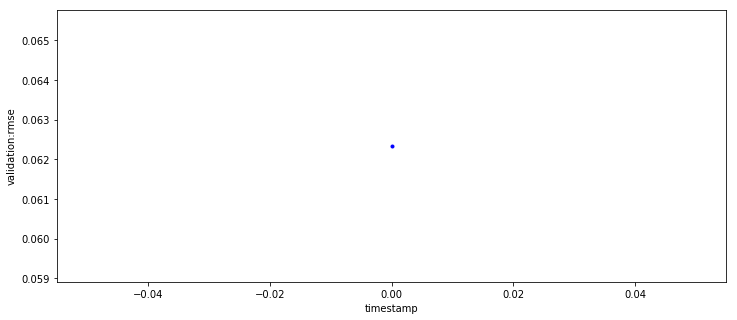

In [34]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = 'validation:rmse'

metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

## Set up hosting for the model
In order to set up hosting, we have to import the model from training to hosting. 

In [43]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-04-13-10-09-05-173
INFO:sagemaker:Creating endpoint with name xgboost-2019-04-13-10-04-43-369


---------------------------------------------------------------!

## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [47]:
from sagemaker.predictor import csv_serializer

test_data_array = test_data.drop(["Rings"], axis=1).as_matrix() #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(1254,)


In [48]:
predictions_array

array([0.3977102 , 0.5685336 , 0.5685336 , ..., 0.54675025, 0.54675025,
       0.5685336 ])

### Delete Endpoint
Once you are done using the endpoint, you can use the following to delete it. 

In [49]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
#bucket_to_delete.objects.all().delete()

INFO:sagemaker:Deleting endpoint with name: xgboost-2019-04-13-10-04-43-369


[{'ResponseMetadata': {'RequestId': '128D653EF1D5C983',
   'HostId': 'qdgr4vcTd4UyNlUsiKGLlbvC1JeZCN68C0q6RV1vUbdIrJ7zCqxgyQf2zxKMbtHXK553zG9vVGQ=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'qdgr4vcTd4UyNlUsiKGLlbvC1JeZCN68C0q6RV1vUbdIrJ7zCqxgyQf2zxKMbtHXK553zG9vVGQ=',
    'x-amz-request-id': '128D653EF1D5C983',
    'date': 'Sat, 13 Apr 2019 10:18:34 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/xgboost-regression-abalone/train/train.csv'},
   {'Key': 'sagemaker/xgboost-regression-abalone/validation/test.csv'},
   {'Key': 'sagemaker/xgboost-regression-abalone/output/xgboost-2019-04-13-10-04-43-369/output/model.tar.gz'},
   {'Key': 'loan/loan.csv'},
   {'Key': 'loan/'},
   {'Key': 'sagemaker/xgboost-regression-abalone/single-xgboost/xgboost-regression-abalone-2019-04-13-09-46-59/output/model.tar.gz'},
   {'Key': 'abalone/abal